## Временный ряды

### Задача: <u>проанализировать ВВП африканской страны Гана.</u>

### Данные: <u>показатели [ВВП Ганы](https://lms.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip) за 62 года.</u>


### Задания для проекта: 
<a class="anchor" id=0></a>

1. [Чтение и визуализация исходных данных.](#1)
2. [Модель скользящего среднего.](#2)
3. [Подбор параметров модели).](#3)
4. [Построение модели по оптимальным параметрам.](#4)
5. [Визуализация результатов.](#5)
6. [Выводы по полученным результатам.](#6)
7. [Проверка на наличие пропущенных дат.](#7)
8. [Проверка на наличие пропущенных значений.](#8)
9. [Заполнение пропусков](#9)
10. [Перестройка модели](#10)
11. [Разница моделей по критерию Акаике](#11)
12. [Волативность временного ряда.](#12)
13. [GARCH-модель для предсказания волатильности.](#13)
14. [LinearRegression для получения прогноза.](#14)
15. [Визуализация предсказаний.](#15)
16. [Выводы по волативности.](#16)
17. [Итоговый вариант.](#17)



### Критерии оцненивания:

| Задача | Балл |
| - | - |
| Временной ряд проанализирован на наличие тренда и сезонности, проверен на стационарность |1|
Выбор модели обоснован |2|
Выполнена интерполяция | 1|
Произведён расчёт волатильности, применена ARCH/GARCH-модель |2 |
Приведено сравнение результатов с результатами применения линейной регрессии |2|
Результаты корректно валидированы | 2 |

### 0. Импортируем нужные библиотеки

In [11]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
#import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from parametricGarch import Garch
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

### 1. Читаем и визуализируем данные <a class="anchor" id=1></a>


[наверх](#0)

In [12]:
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df.tail()

,gdp
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


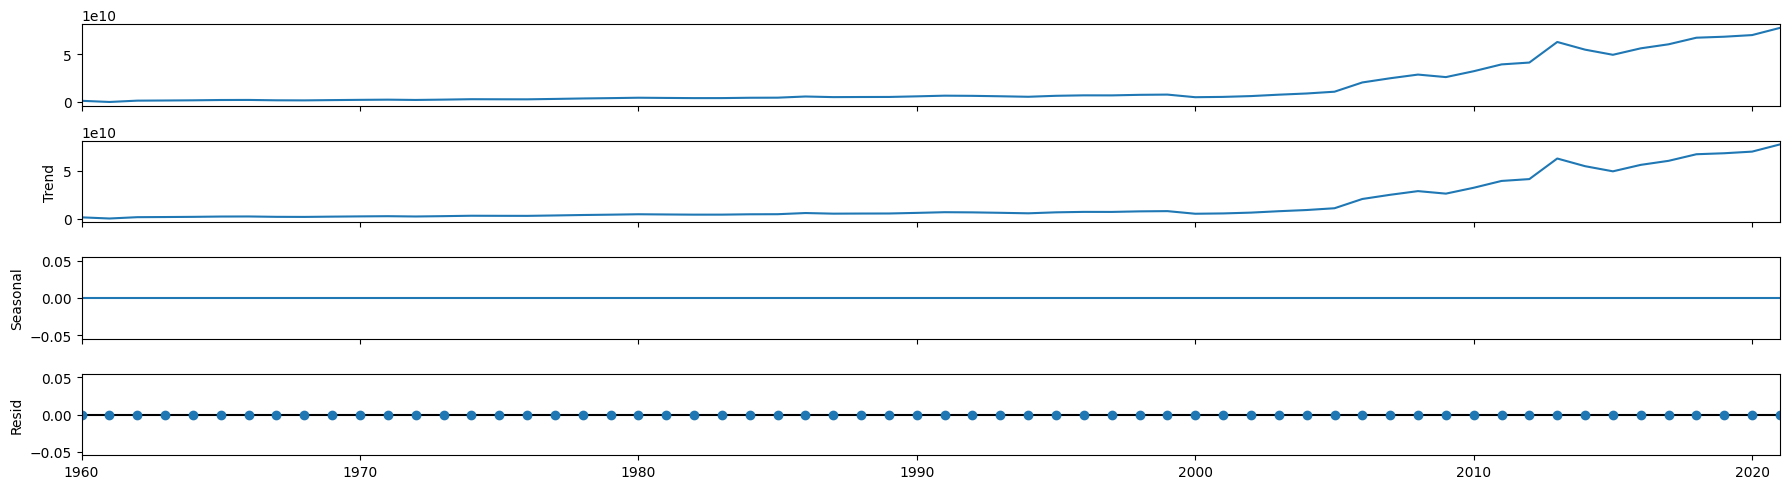

In [13]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

### Первичный выводы:

* Присутствует явно выраженный тренд роста

* Сезонность отсутствует

In [14]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [15]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(df)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

2022-01-01    7.507760e+10
Freq: AS-JAN, dtype: float64


### 2. Модель скользящего среднего. <a class="anchor" id=2></a>

[наверх](#0)

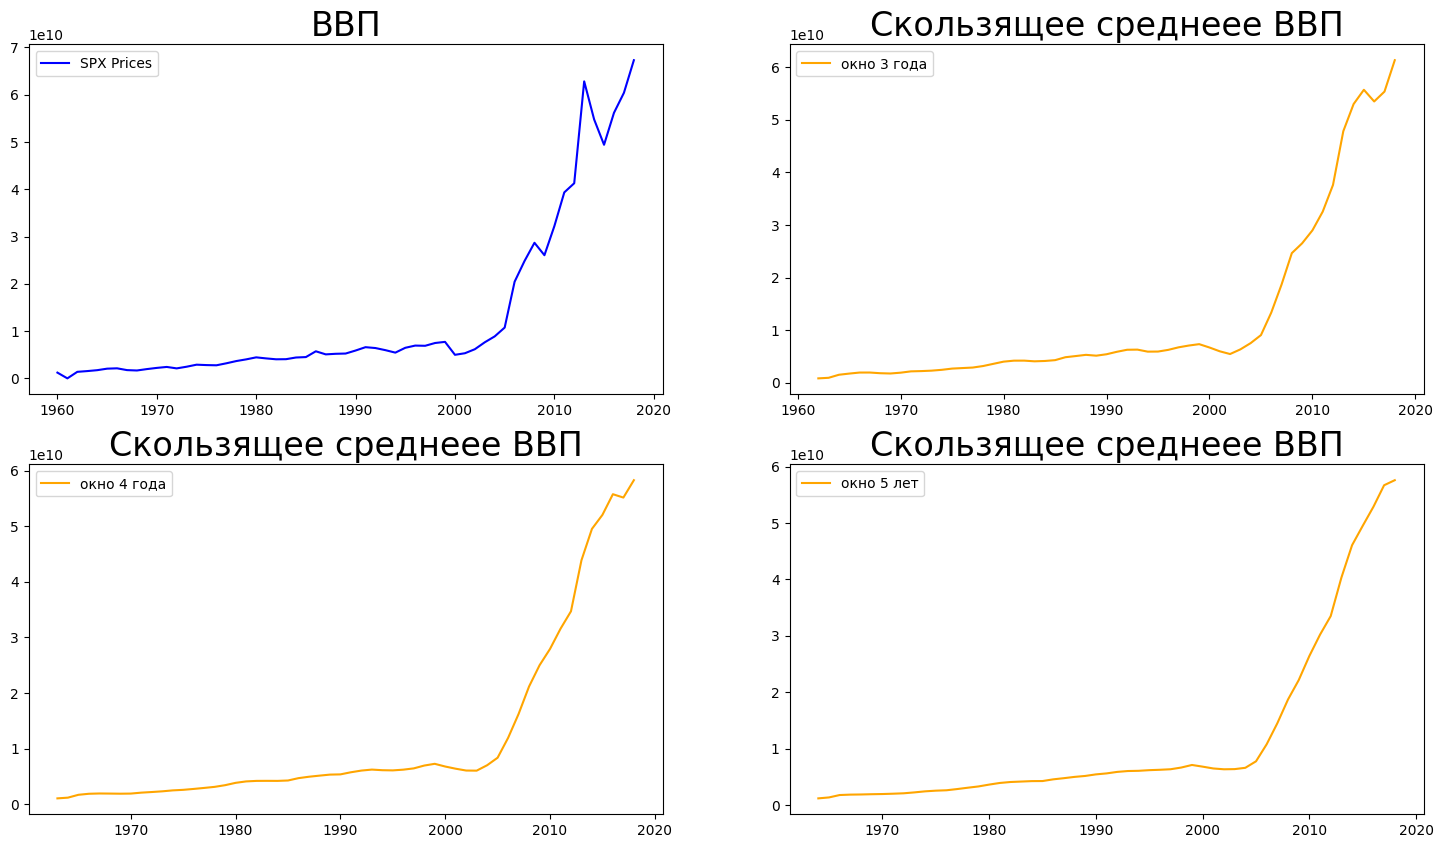

In [16]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 3 года (Window = 3)
ax[0, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[0, 0].set_title("ВВП", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=3).mean(),
    color="orange",
    label="окно 3 года")
ax[0, 1].set_title("Скользящее среднеее ВВП", size=24)
ax[0, 1].legend()


# Окно в 5 лет (Window = 5)
ax[1, 0].plot(
    train_df.rolling(window=4).mean(), 
    color="orange", label="окно 4 года")
ax[1, 0].set_title("Скользящее среднеее ВВП", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="окно 5 лет")
ax[1, 1].set_title("Скользящее среднеее ВВП", size=24)
ax[1, 1].legend()

plt.show()

Построим модель `ARMA`

In [17]:
model = SARIMAX(train_df.gdp)
model_fit = model.fit()

pred_df = pd.DataFrame(index=test_df.index)

pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = test_df["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))

old_aic = model_fit.aic

model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08268D+01    |proj g|=  3.23584D+01

At iterate    5    f=  2.38790D+01    |proj g|=  3.75068D-01

At iterate   10    f=  2.35980D+01    |proj g|=  1.72740D-02

At iterate   15    f=  2.35726D+01    |proj g|=  4.97911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     19      1     0     0   5.433D-06   2.357D+01
  F =   23.572311278159198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1390.766
Date:                Mon, 08 Jan 2024   AIC                           2785.533
Time:                        01:31:52   BIC                           2789.688
Sample:                    01-01-1960   HQIC                          2787.155
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9964      0.006    166.517      0.000       0.985       1.008
sigma2      1.358e+19   1.96e-23   6.93e+41      0.000    1.36e+19    1.36e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               479.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             189.08   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

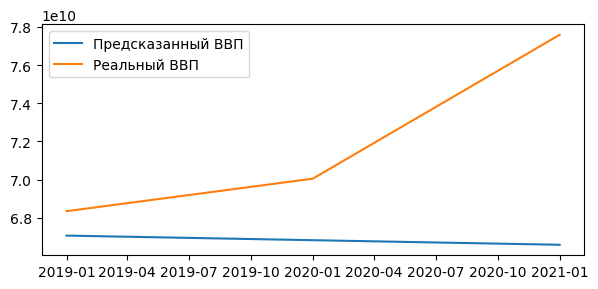

In [18]:
plt.rcParams["figure.figsize"] = 7, 3
plt.plot(
    pred_df.model_preds,
    label="Предсказанный ВВП")
plt.plot(
    pred_df.gdp,
    label="Реальный ВВП")
plt.legend()

### Промежуточные выводы:

* C параметрами по умолчанию предсказания модели оставляют делать лучшего

### 3. Подбор параметров модели. <a class="anchor" id=3></a>

[наверх](#0)

Для определения параметров $p$ и $q$ построим коррелограммs (`ACF, PACF`)

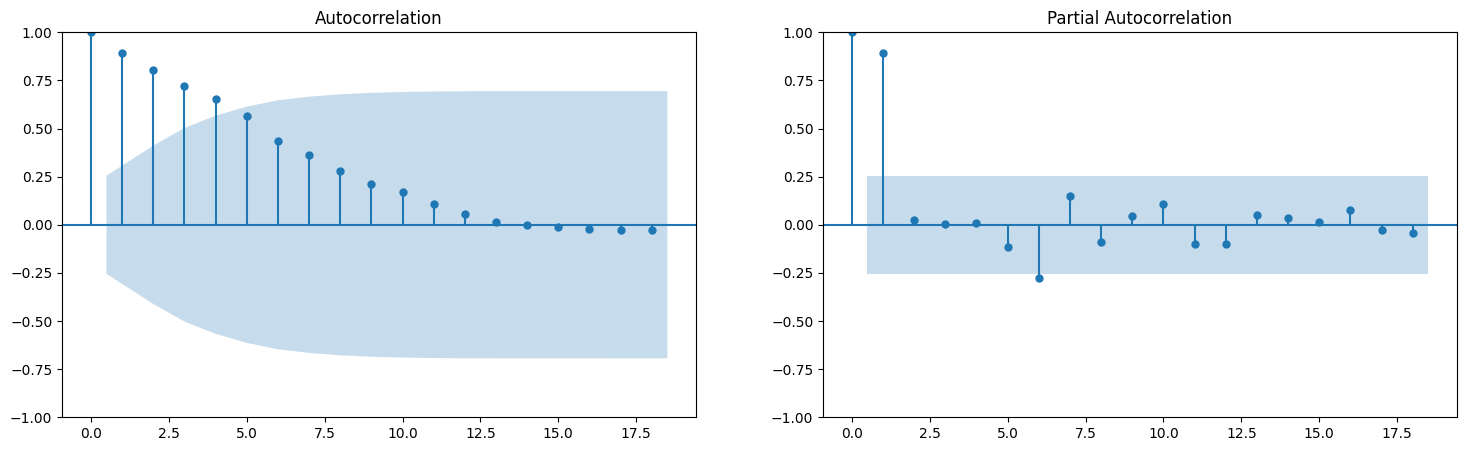

In [19]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1])
    plt.show()

plot_acf_pacf(train_df["gdp"].dropna())

Для определения $d$ проведеём тест Дики-Фуллера

In [20]:
test = adfuller(train_df["gdp"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Исходный ряд нестационарен. Будем дифференцировать ряд, пока не добьёмся стационарности. 

In [21]:
test_1 = adfuller(train_df["gdp"].diff().dropna()) # Первое дифференцирование
print("adf: ", test_1[0])
print("p-value: ", test_1[1])
print("Critical values: ", test_1[4])
if test_1[0] > test_1[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [22]:
test_2 = adfuller(train_df["gdp"].diff().diff().dropna()) # Второе дифференцирование
print("adf: ", test_2[0])
print("p-value: ", test_2[1])
print("Critical values: ", test_2[4])
if test_2[0] > test_2[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


Порядок дифференциирования, при котором ряд стационарен $d=2$

Проверим разные значения $p$ и $q$

In [23]:
model_1 = SARIMAX(
    train_df["gdp"].dropna(), order=(1, 1, 3))
model_fit_1 = model_1.fit()

model_2 = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3))
model_fit_2 = model_2.fit()

model_3 = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 2, 3))
model_fit_3 = model_3.fit()

model_4 = SARIMAX(
    train_df["gdp"].dropna(), order=(1, 2, 3))
model_fit_4 = model_4.fit()


pred_df = pd.DataFrame(index=test_df.index)
pred_df["model_1"] = model_fit_1.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_2"] = model_fit_2.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_3"] = model_fit_3.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_4"] = model_fit_4.predict(
    start=test_df.index[0], end=test_df.index[-1])

pred_df["gdp"] = test_df["gdp"]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30458D+01    |proj g|=  5.91275D-02

At iterate    5    f=  2.30317D+01    |proj g|=  5.52306D-03

At iterate   10    f=  2.30020D+01    |proj g|=  3.01478D-02

At iterate   15    f=  2.29978D+01    |proj g|=  2.67570D-02

At iterate   20    f=  2.29960D+01    |proj g|=  5.47414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     0     0   3.371D-06   2.300D+01
  F =   22.995984583016924     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31310D+01    |proj g|=  2.27697D-01

At iterate    5    f=  2.30754D+01    |proj g|=  2.35043D-01

At iterate   10    f=  2.29751D+01    |proj g|=  2.29366D-02

At iterate   15    f=  2.29690D+01    |proj g|=  5.73394D-03

At iterate   20    f=  2.29688D+01    |proj g|=  1.66182D-03


 This problem is unconstrained.



At iterate   25    f=  2.29685D+01    |proj g|=  8.64401D-03

At iterate   30    f=  2.29680D+01    |proj g|=  1.09867D-02

At iterate   35    f=  2.29679D+01    |proj g|=  8.07525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     47      1     0     0   2.256D-05   2.297D+01
  F =   22.967899702038341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29726D+01    |proj g|=  6.12749D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.26326D+01    |proj g|=  5.26775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   3.745D-06   2.263D+01
  F =   22.632606677412454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30134D+01    |proj g|=  6.42402D-01

At iterate    5    f=  2.26367D+01    |proj g|=  1.37821D-02

At iterate   10    f=  2.26342D+01    |proj g|=  2.11133D-03

At iter

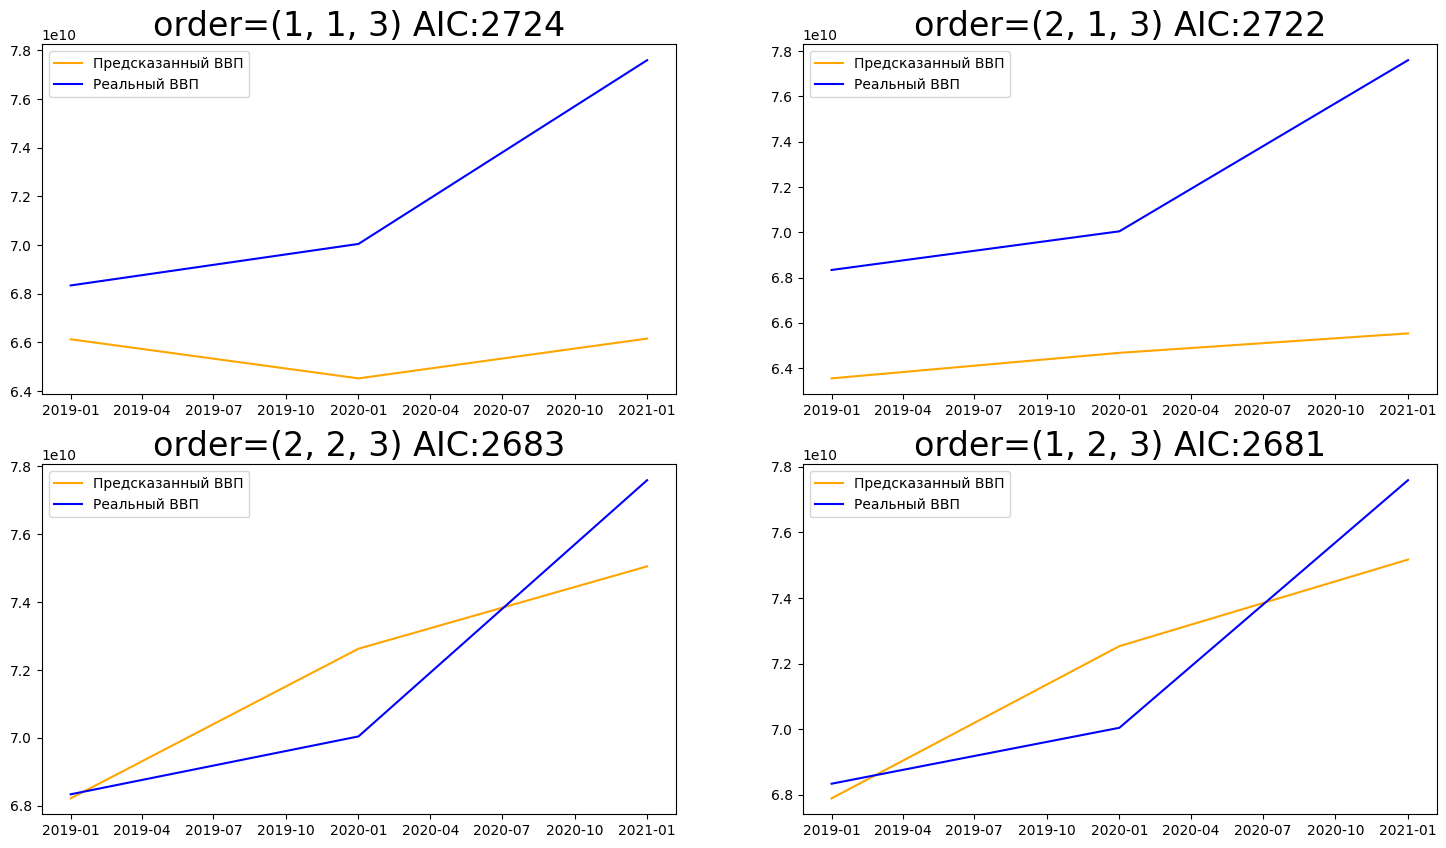

In [24]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(pred_df.model_1, color="orange", label="Предсказанный ВВП")
ax[0, 0].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[0, 0].set_title(f"order=(1, 1, 3) AIC:{round(model_fit_1.aic)}", size=24)
ax[0, 0].legend()

ax[0, 1].plot(pred_df.model_2, color="orange", label="Предсказанный ВВП",)
ax[0, 1].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[0, 1].set_title(f"order=(2, 1, 3) AIC:{round(model_fit_2.aic)}", size=24)
ax[0, 1].legend()

ax[1, 0].plot(pred_df.model_3, color="orange", label="Предсказанный ВВП")
ax[1, 0].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[1, 0].set_title(f"order=(2, 2, 3) AIC:{round(model_fit_3.aic)}", size=24)
ax[1, 0].legend()

ax[1, 1].plot(pred_df.model_4, color="orange", label="Предсказанный ВВП",)
ax[1, 1].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[1, 1].set_title(f"order=(1, 2, 3) AIC:{round(model_fit_4.aic)}", size=24)
ax[1, 1].legend()

plt.show()

Воспользуемся `pmdarima`

In [25]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2493.722, Time=0.34 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.43 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.67 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.06 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.20 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.16 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.30 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.45 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   59
Model:             SARIMAX(4, 1, 2)x(0, 1, 2, 5)   Log Likelihood               -1235.132
Date:                           Mon, 08 Jan 2024   AIC                           2488.264
Time:                                   01:32:13   BIC                           2505.997
Sample:                               01-01-1960   HQIC                          2495.083
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0810      0.231      0.351      0.726      -0.372       0.534
ar.L2         -1.0582      0.253     -4.187      0.000      -1.554      -0.563
ar.L3          0.4042      0.354      1.143      0.253      -0.289       1.097
ar.L4         -0.3468      0.366     -0.949      0.343      -1.063       0.370
ma.L1         -0.1224      0.179     -0.685      0.493      -0.473       0.228
ma.L2          0.9391      0.255      3.678      0.000       0.439       1.440
ma.S.L5        0.0691      0.425      0.163      0.871      -0.764       0.903
ma.S.L10      -0.4332      0.329     -1.317      0.188      -1.078       0.212
sigma2      1.444e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                55.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              59.75   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.99e+54. Standard errors may be unstable.
"""

`pmdarima` советует применить следующие параметры 
```python 
order=(2, 1, 3), 
seasonal_order=(0, 1, 2, 5)
```
Данные параметры соответствуют полученным нами параметрам, на них и остановимся.

### 4. Построим модель с наилучшими параметрами. <a class="anchor" id=4></a>

[наверх](#0)

In [26]:
model = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit = model.fit()

pred_df = pd.DataFrame(index=df.index)
pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1])


pred_df["gdp"] = df["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11697D+01    |proj g|=  3.72492D-01

At iterate    5    f=  2.10269D+01    |proj g|=  4.40461D-02


 This problem is unconstrained.



At iterate   10    f=  2.10171D+01    |proj g|=  3.68233D-02

At iterate   15    f=  2.09666D+01    |proj g|=  3.26163D-02

At iterate   20    f=  2.09512D+01    |proj g|=  5.73293D-02

At iterate   25    f=  2.09366D+01    |proj g|=  4.17536D-02

At iterate   30    f=  2.09355D+01    |proj g|=  2.93018D-03

At iterate   35    f=  2.09354D+01    |proj g|=  1.66692D-03

At iterate   40    f=  2.09354D+01    |proj g|=  8.12243D-03

At iterate   45    f=  2.09347D+01    |proj g|=  1.22233D-02

At iterate   50    f=  2.09345D+01    |proj g|=  1.58267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

### 5. Визуализируем промежуточные результаты. <a class="anchor" id=5></a>

[наверх](#0)

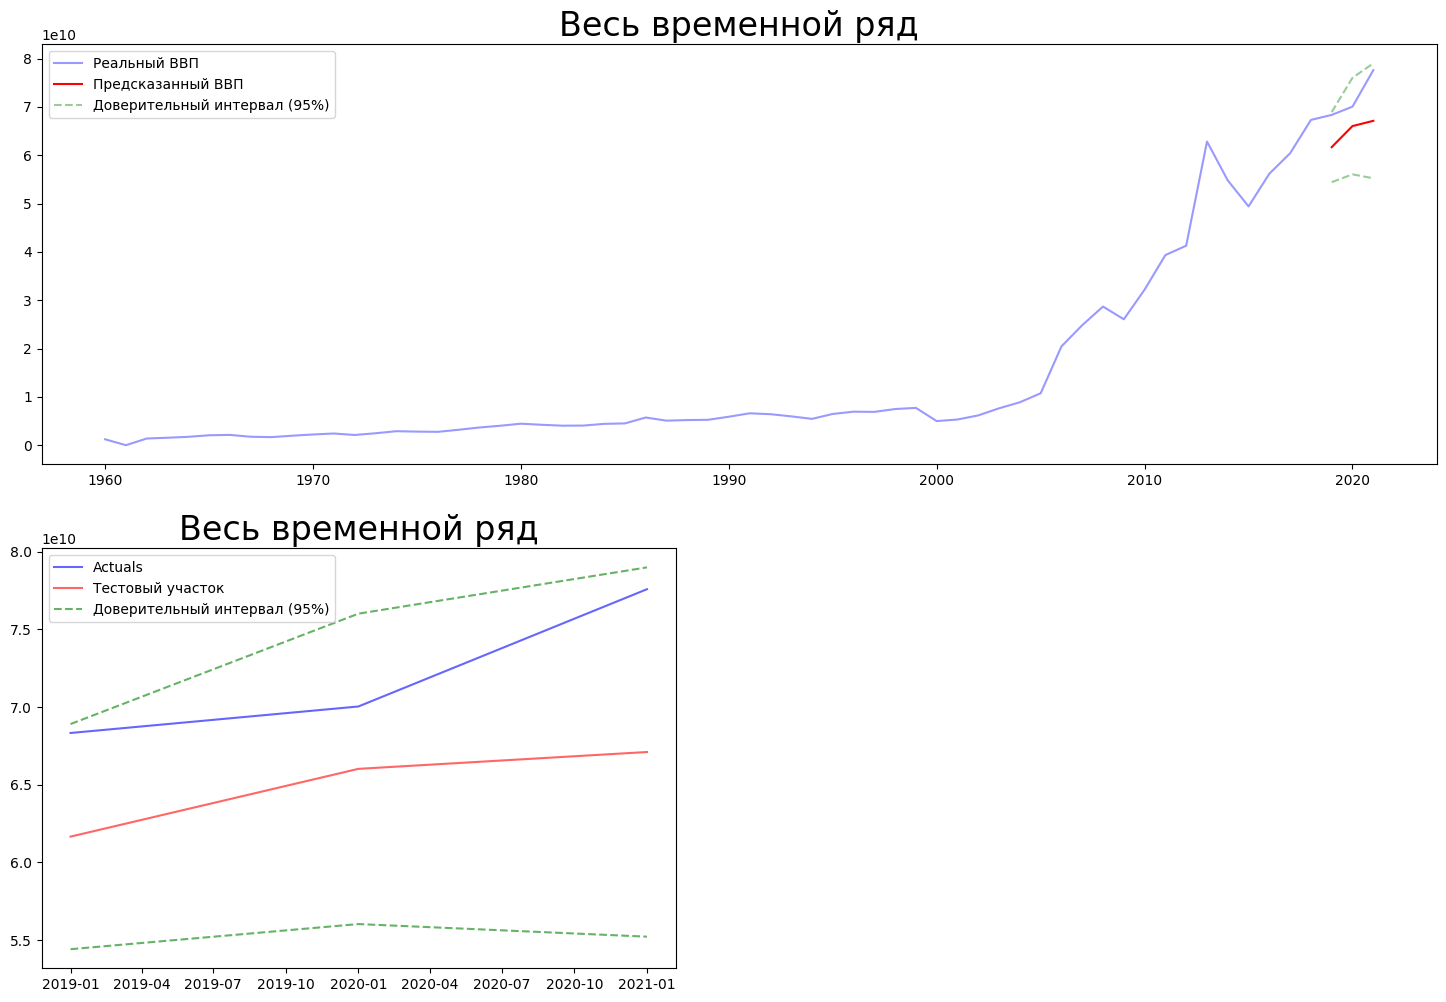

In [27]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Реальный ВВП", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный ВВП",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Тестовый участок",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.show()

### 6. Промежеточные разельтаты <a class="anchor" id=6></a>

* С подобранными параметрами модель делает более правдоподобные предсказания


[наверх](#0)

### 7. Проверим пропущенные даты. <a class="anchor" id=7></a>

[наверх](#0)

In [28]:
print(df.asfreq(freq='AS'))
print()
print(f'Пропущенные даты: {(np.arange(1960, 2022) - df.index.year).any() != 0}')

                     gdp
year                    
1960-01-01  1.217087e+09
1961-01-01  0.000000e+00
1962-01-01  1.382353e+09
1963-01-01  1.540616e+09
1964-01-01  1.731092e+09
...                  ...
2017-01-01  6.040638e+10
2018-01-01  6.729928e+10
2019-01-01  6.833754e+10
2020-01-01  7.004320e+10
2021-01-01  7.759428e+10

[62 rows x 1 columns]

Пропущенные даты: False


### 8. Проверим пропущенные значения. <a class="anchor" id=8></a>

[наверх](#0)

In [29]:
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x==0 else x)
df = df.interpolate(method='linear')
print(f'Пропуски в значениях: {df.gdp.isna().any()}')

Пропуски в значениях: False


### 9. Заменим пропуски интерполяцией. <a class="anchor" id=9></a>

[наверх](#0)

In [30]:
df = df.interpolate(method='linear')
print(f'Пропуски в значениях: {df.gdp.isna().any()}')

Пропуски в значениях: False


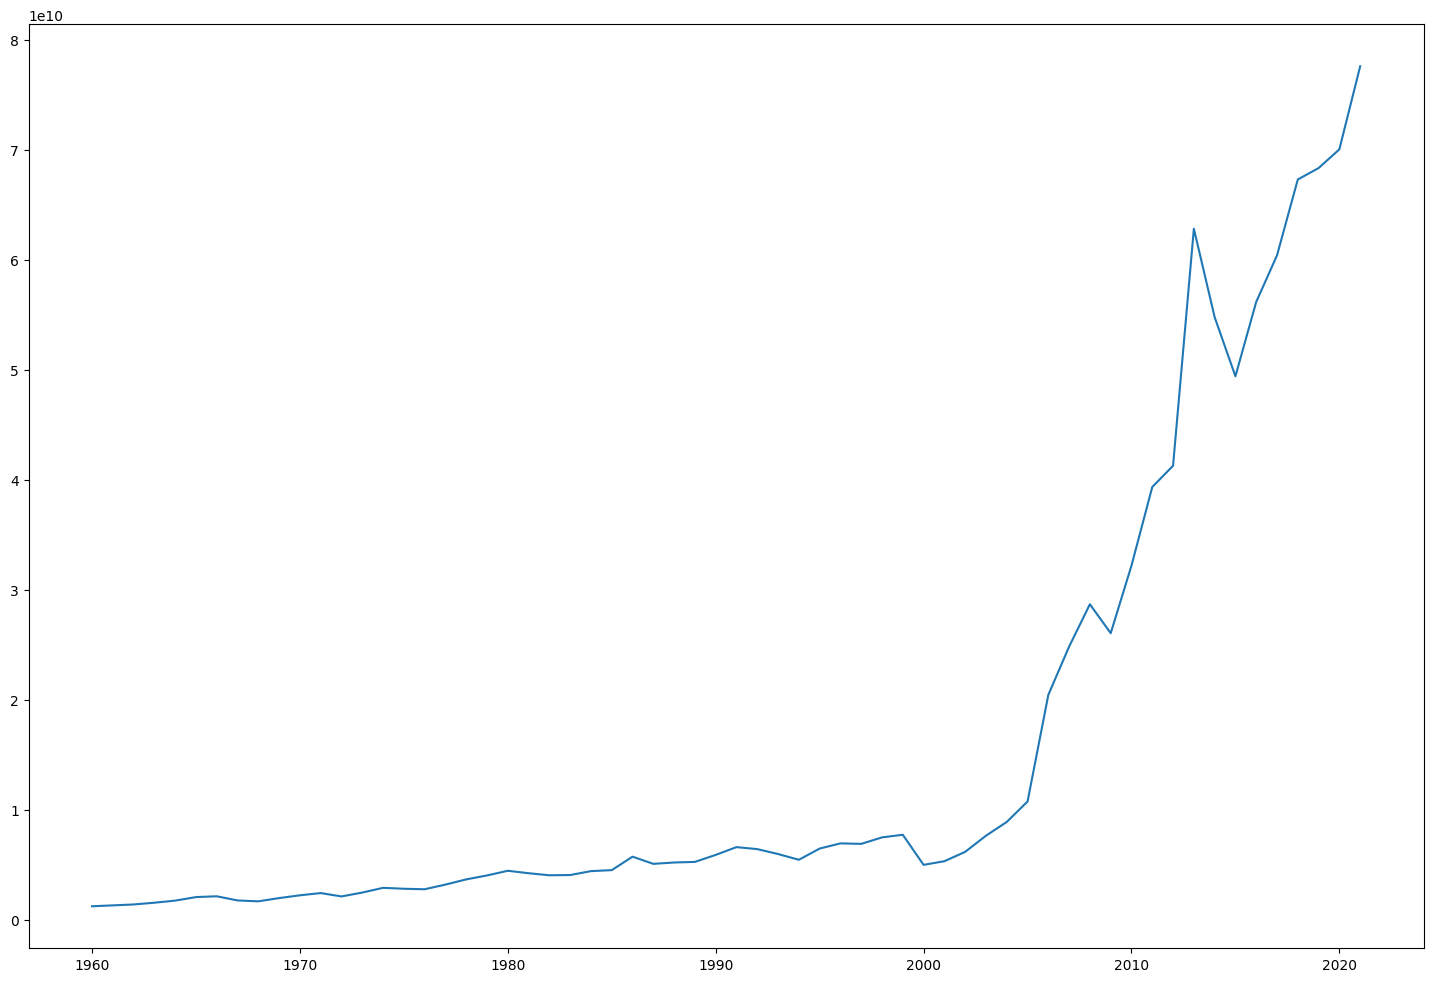

In [31]:
plt.plot(df)

### 10. Построим модель на откорректированных данных. <a class="anchor" id=10></a>

[наверх](#0)

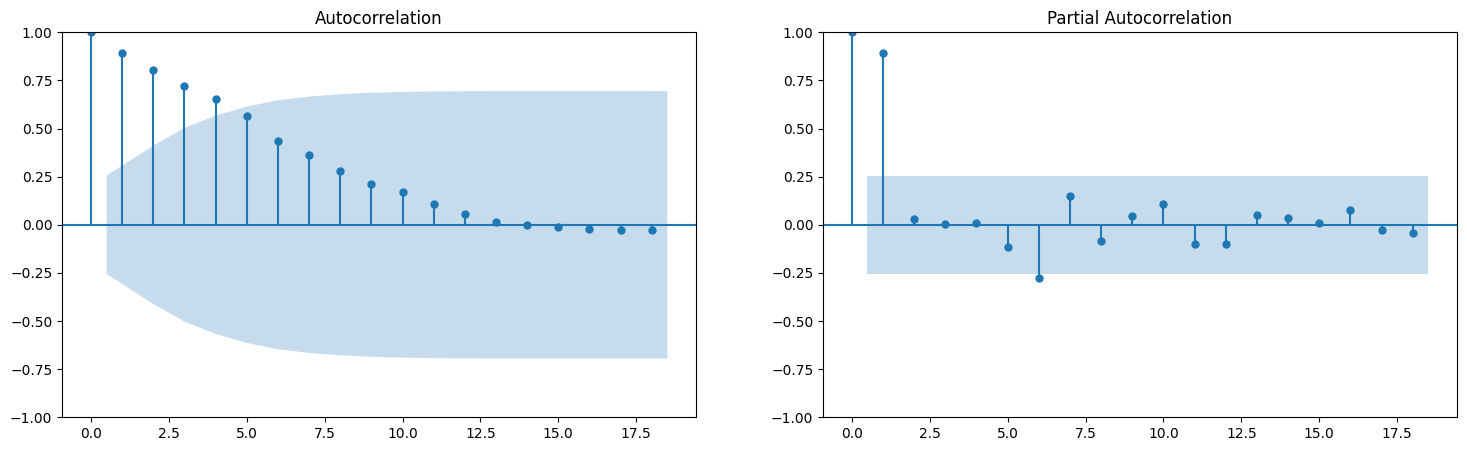

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [32]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

plot_acf_pacf(train_df["gdp"].dropna())

test = adfuller(train_df["gdp"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

In [33]:
test_1 = adfuller(train_df["gdp"].diff().dropna()) # Первое дифференцирование
print("adf: ", test_1[0])
print("p-value: ", test_1[1])
print("Critical values: ", test_1[4])
if test_1[0] > test_1[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.8255652246436
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [34]:
test_2 = adfuller(train_df["gdp"].diff().diff().dropna()) # Первое дифференцирование
print("adf: ", test_2[0])
print("p-value: ", test_2[1])
print("Critical values: ", test_2[4])
if test_2[0] > test_2[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.63463474600784
p-value:  0.08604813722197724
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


In [35]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.412, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.105, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.664, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.160, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2492.573, Time=0.16 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.412, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.391, Time=0.06 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2489.992, Time=0.21 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2491.982, Time=0.34 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2491.973, Time=0.45 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=inf, Time=0.23 sec
 ARIMA(2,1,1)(1,1,2)[5]            

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.053
Date:                                Mon, 08 Jan 2024   AIC                           2486.105
Time:                                        01:32:33   BIC                           2501.867
Sample:                                    01-01-1960   HQIC                          2492.166
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4171      0.140     -2.972      0.003      -0.692      -0.142
ar.L2         -0.9828      0.190     -5.168      0.000      -1.355      -0.610
ma.L1          0.3822      0.242      1.579      0.114      -0.092       0.857
ma.L2          0.9253      0.201      4.606      0.000       0.532       1.319
ma.L3          0.4403      0.187      2.351      0.019       0.073       0.807
ma.S.L5        0.0435      0.265      0.164      0.870      -0.476       0.563
ma.S.L10      -0.4445      0.321     -1.385      0.166      -1.073       0.184
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             180.87   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+54. Standard errors may be unstable.
"""

```python 
order=(2, 1, 3), 
seasonal_order=(0, 1, 2, 5)
```

In [36]:
model_inter = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit_inter = model_inter.fit()

model_fit_inter.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11198D+01    |proj g|=  3.13345D-01

At iterate    5    f=  2.10204D+01    |proj g|=  4.23944D-02



At iterate   10    f=  2.10173D+01    |proj g|=  8.26565D-03


 This problem is unconstrained.



At iterate   15    f=  2.10131D+01    |proj g|=  1.56047D-01

At iterate   20    f=  2.09952D+01    |proj g|=  1.08478D-01

At iterate   25    f=  2.09710D+01    |proj g|=  7.67184D-02

At iterate   30    f=  2.09618D+01    |proj g|=  1.19739D-02

At iterate   35    f=  2.09611D+01    |proj g|=  2.56075D-02

At iterate   40    f=  2.09401D+01    |proj g|=  3.74658D-02

At iterate   45    f=  2.09336D+01    |proj g|=  2.75546D-02

At iterate   50    f=  2.09331D+01    |proj g|=  1.08914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.089D-03   2.093D+01
  F =   20.9330934704

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.053
Date:                                Mon, 08 Jan 2024   AIC                           2486.105
Time:                                        01:32:34   BIC                           2501.867
Sample:                                    01-01-1960   HQIC                          2492.166
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4171      0.140     -2.972      0.003      -0.692      -0.142
ar.L2         -0.9828      0.190     -5.168      0.000      -1.355      -0.610
ma.L1          0.3822      0.242      1.579      0.114      -0.092       0.857
ma.L2          0.9253      0.201      4.606      0.000       0.532       1.319
ma.L3          0.4403      0.187      2.351      0.019       0.073       0.807
ma.S.L5        0.0435      0.265      0.164      0.870      -0.476       0.563
ma.S.L10      -0.4445      0.321     -1.385      0.166      -1.073       0.184
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             180.87   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+54. Standard errors may be unstable.
"""

### 11. Проверим улучшилась ли ключевая метрика модели. <a class="anchor" id=11></a>

[наверх](#0)

In [37]:
print(f'По критерию Акаике новая модель лучше старой на: {round(old_aic - model_fit_inter.aic)}')

По критерию Акаике новая модель лучше старой на: 299


### 12. Определим волативность ряда. <a class="anchor" id=12></a>

[наверх](#0)

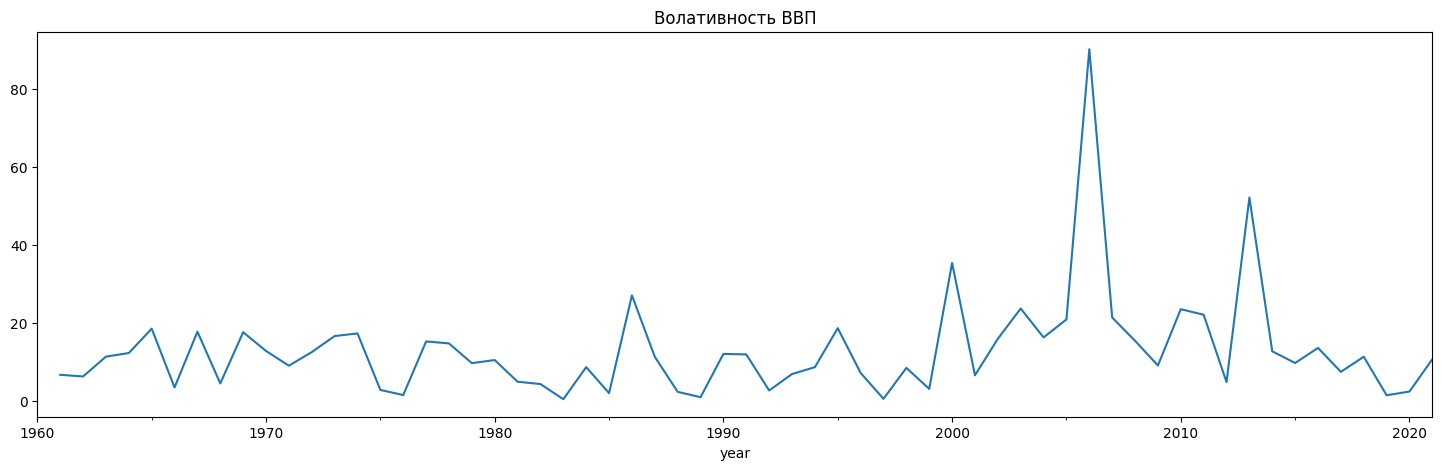

In [38]:
df['gdp_vol'] = (df.gdp - df.gdp.shift(1))/df.gdp.shift(1)
df['gdp_vol'] = df.gdp.pct_change(1).mul(100).abs()

df['gdp_vol'].plot()
plt.title('Волативность ВВП')
plt.show()

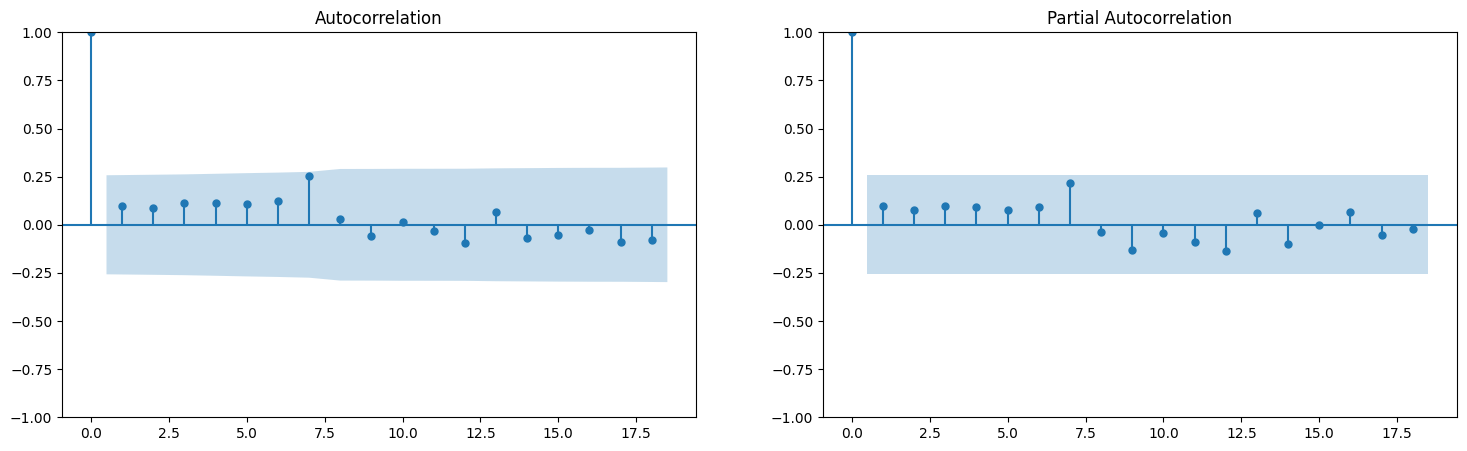

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [39]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

plot_acf_pacf(train_df["gdp_vol"].dropna())

test = adfuller(train_df["gdp_vol"].dropna()) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

Iteration:      3,   Func. Count:     23,   Neg. LLF: 240.39115594313043
Iteration:      6,   Func. Count:     43,   Neg. LLF: 226.3705004977227
Iteration:      9,   Func. Count:     62,   Neg. LLF: 225.85405160732438
Iteration:     12,   Func. Count:     81,   Neg. LLF: 225.84686361289084
Iteration:     15,   Func. Count:    100,   Neg. LLF: 225.84671288872923
Iteration:     18,   Func. Count:    120,   Neg. LLF: 225.84668016721844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 225.8466794646595
            Iterations: 18
            Function evaluations: 121
            Gradient evaluations: 18


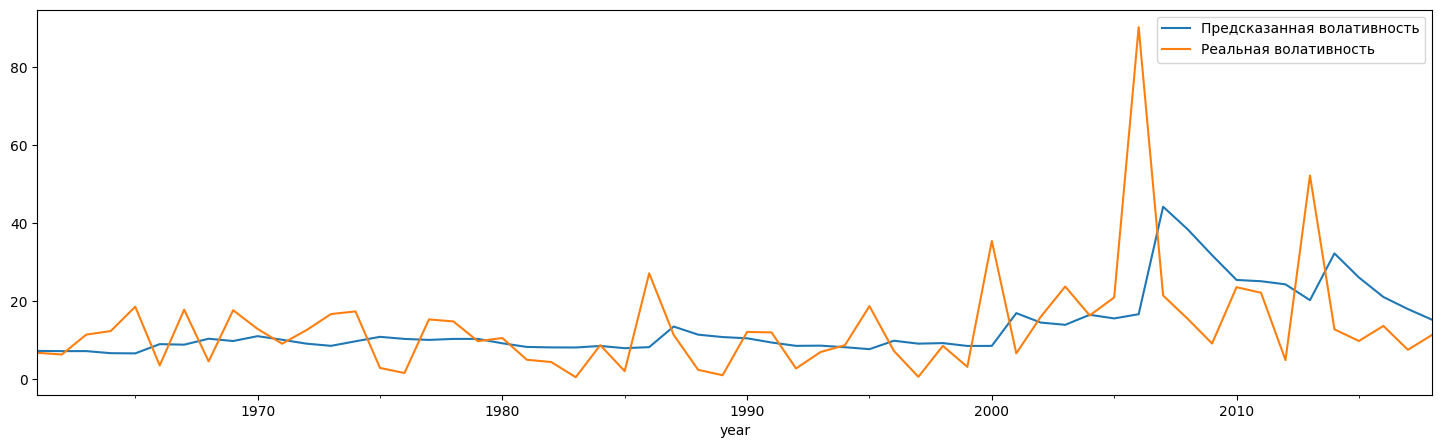

In [40]:
from arch import arch_model
am = arch_model(train_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, train_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

Iteration:      3,   Func. Count:     20,   Neg. LLF: 8.468630830131094
Iteration:      6,   Func. Count:     38,   Neg. LLF: 8.459727908797973
Iteration:      9,   Func. Count:     56,   Neg. LLF: 8.459533545654926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.459533545654926
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


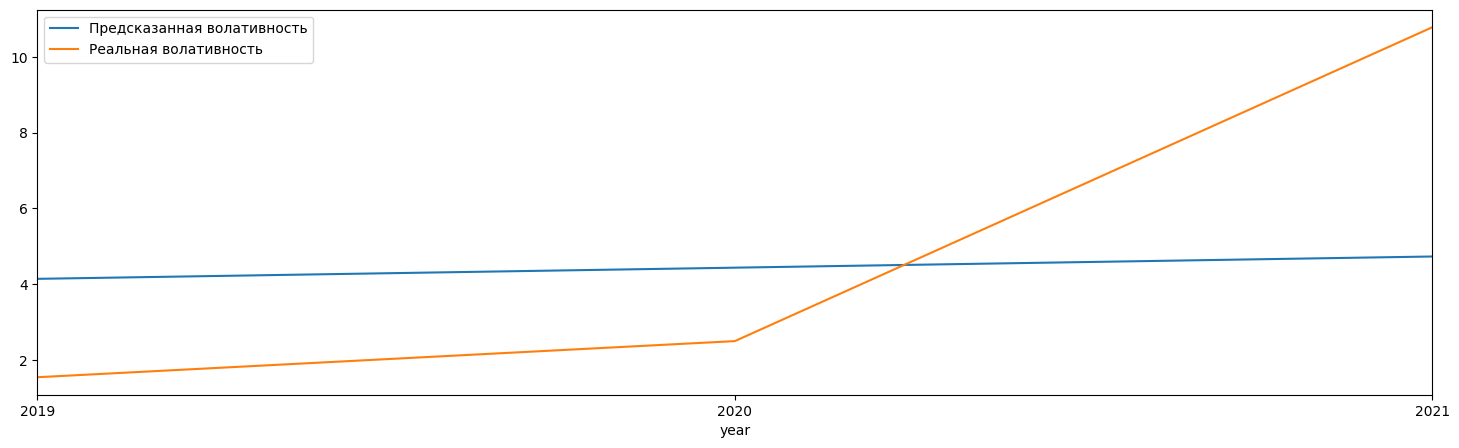

In [41]:
from arch import arch_model
am = arch_model(test_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, test_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

Модель предсказывает лютую волативность, я не согласен с моделью. Может бы я разберусь,что я делаю не так, а может быть нет.

### 14 - 15. Линейная регрессия и визуализация <a class="anchor" id=14></a> <a class="anchor" id=15></a>

[наверх](#0)

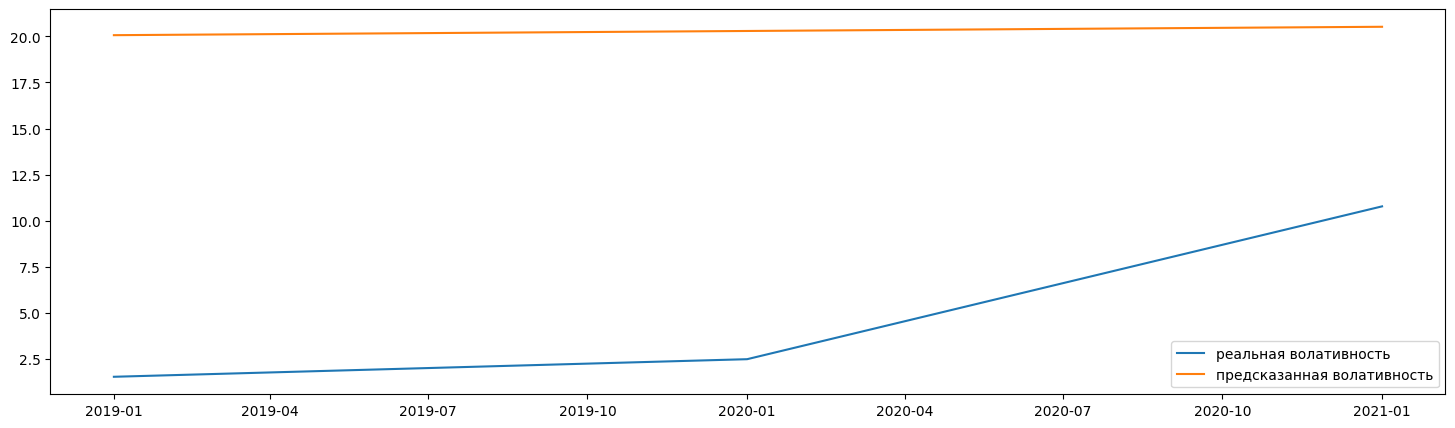

In [42]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test, label='реальная волативность')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='предсказанная волативность')
plt.legend()
plt.show()

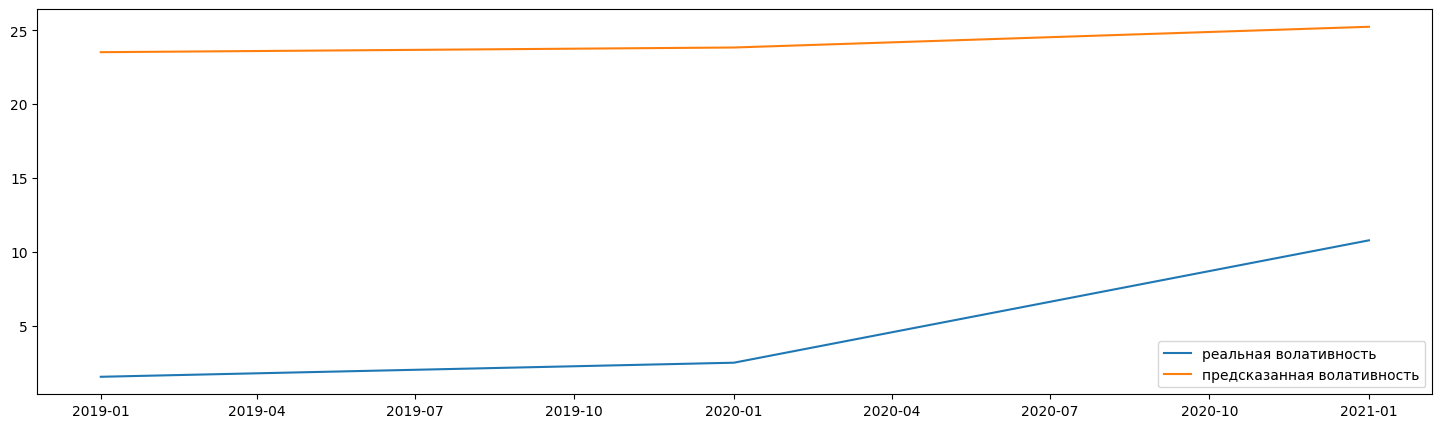

In [43]:
X_train = train_df.drop('gdp_vol', axis=1)
y_train = train_df.drop('gdp', axis=1)

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test_df.drop('gdp_vol', axis=1)
y_test = test_df.drop('gdp', axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
y_test['pred_vol'] = lr_predict

plt.plot(y_test.gdp_vol, label='реальная волативность')
plt.plot(y_test.pred_vol, label='предсказанная волативность')
plt.legend()
plt.show()

### Выводы по волативности:

* Данные показывают слабую волативность (логично, данных мало, и они не предполагают сильного разброса величин)

* Предсказания `GARCH` выглядят поадекватнее `LinearRegression`.

### 16. Валидация временного ряда <a class="anchor" id=16>

[наверх](#0)

In [44]:
tscv = TimeSeriesSplit(n_splits=5, test_size=7)

train_test_groups = tscv.split(df.gdp)
train_test_groups


train = []
test = []
i = 0
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index), "Split: ", i)
    train.append(train_index)
    test.append(test_index)
    i += 1

TRAIN size: 27 TEST size: 7 Split:  0
TRAIN size: 34 TEST size: 7 Split:  1
TRAIN size: 41 TEST size: 7 Split:  2
TRAIN size: 48 TEST size: 7 Split:  3
TRAIN size: 55 TEST size: 7 Split:  4


In [45]:
model_0 = SARIMAX(
    df.gdp.iloc[train[0]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_0 = model_0.fit()
cv_aic_0 = model_0.aic

model_1 = SARIMAX(
    df.gdp.iloc[train[1]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_1 = model_1.fit()
cv_aic_1 = model_1.aic

model_2 = SARIMAX(
    df.gdp.iloc[train[2]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_2 = model_2.fit()
cv_aic_2 = model_2.aic

model_3 = SARIMAX(
    df.gdp.iloc[train[3]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_3 = model_3.fit()
cv_aic_3 = model_3.aic

model_4 = SARIMAX(
    df.gdp.iloc[train[4]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_4 = model_4.fit()
cv_aic_4 = model_4.aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66448D+01    |proj g|=  1.53431D-01

At iterate    5    f=  1.65753D+01    |proj g|=  8.36800D-03

At iterate   10    f=  1.65749D+01    |proj g|=  2.38337D-03


 This problem is unconstrained.



At iterate   15    f=  1.65722D+01    |proj g|=  8.78946D-03

At iterate   20    f=  1.65703D+01    |proj g|=  3.71957D-03

At iterate   25    f=  1.65688D+01    |proj g|=  9.87445D-03

At iterate   30    f=  1.65686D+01    |proj g|=  3.42221D-04

At iterate   35    f=  1.65686D+01    |proj g|=  1.90461D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     43      1     0     0   1.905D-06   1.657D+01
  F =   16.568604150182939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.73996D+01    |proj g|=  8.68056D-04

At iterate   15    f=  1.73996D+01    |proj g|=  2.35688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     20      1     0     0   1.689D-05   1.740D+01
  F =   17.399625492640293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87188D+01    |proj g|=  1.95223D-01


 This problem is unconstrained.



At iterate    5    f=  1.84955D+01    |proj g|=  3.85887D-02

At iterate   10    f=  1.84869D+01    |proj g|=  1.89267D-02

At iterate   15    f=  1.84845D+01    |proj g|=  4.73380D-03

At iterate   20    f=  1.84831D+01    |proj g|=  4.63849D-02

At iterate   25    f=  1.84816D+01    |proj g|=  1.18679D-02

At iterate   30    f=  1.84812D+01    |proj g|=  5.05979D-03

At iterate   35    f=  1.84812D+01    |proj g|=  4.68792D-03

At iterate   40    f=  1.84810D+01    |proj g|=  6.20131D-04

At iterate   45    f=  1.84810D+01    |proj g|=  8.93127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     58   

 This problem is unconstrained.



At iterate   10    f=  1.96951D+01    |proj g|=  2.18187D-02

At iterate   15    f=  1.96930D+01    |proj g|=  4.85269D-03

At iterate   20    f=  1.96921D+01    |proj g|=  4.56419D-02

At iterate   25    f=  1.96913D+01    |proj g|=  1.23219D-02

At iterate   30    f=  1.96912D+01    |proj g|=  2.43893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     38      1     0     0   3.960D-05   1.969D+01
  F =   19.691244963979429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.06527D+01    |proj g|=  1.78361D-01

At iterate   10    f=  2.06434D+01    |proj g|=  9.19897D-03

At iterate   15    f=  2.06418D+01    |proj g|=  4.55777D-03

At iterate   20    f=  2.06414D+01    |proj g|=  7.20339D-03

At iterate   25    f=  2.06412D+01    |proj g|=  2.46729D-03

At iterate   30    f=  2.06412D+01    |proj g|=  3.78172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     37      1     0     0   1.778D-05   2.064D+01
  F =   20.641234733811121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [46]:
pred_df = pd.DataFrame(index = df.index)

pred_df["model_0_preds"] = model_0.predict(start=df.gdp.iloc[test[0]].index[0] , end=df.gdp.iloc[test[0]].index[-1])
pred_df["model_1_preds"] = model_1.predict(start=df.gdp.iloc[test[1]].index[0] , end=df.gdp.iloc[test[1]].index[-1])
pred_df["model_2_preds"] = model_2.predict(start=df.gdp.iloc[test[2]].index[0] , end=df.gdp.iloc[test[2]].index[-1])
pred_df["model_3_preds"] = model_3.predict(start=df.gdp.iloc[test[3]].index[0] , end=df.gdp.iloc[test[3]].index[-1])
pred_df["model_4_preds"] = model_4.predict(start=df.gdp.iloc[test[4]].index[0] , end=df.gdp.iloc[test[4]].index[-1])
pred_df["gdp"] = df["gdp"]

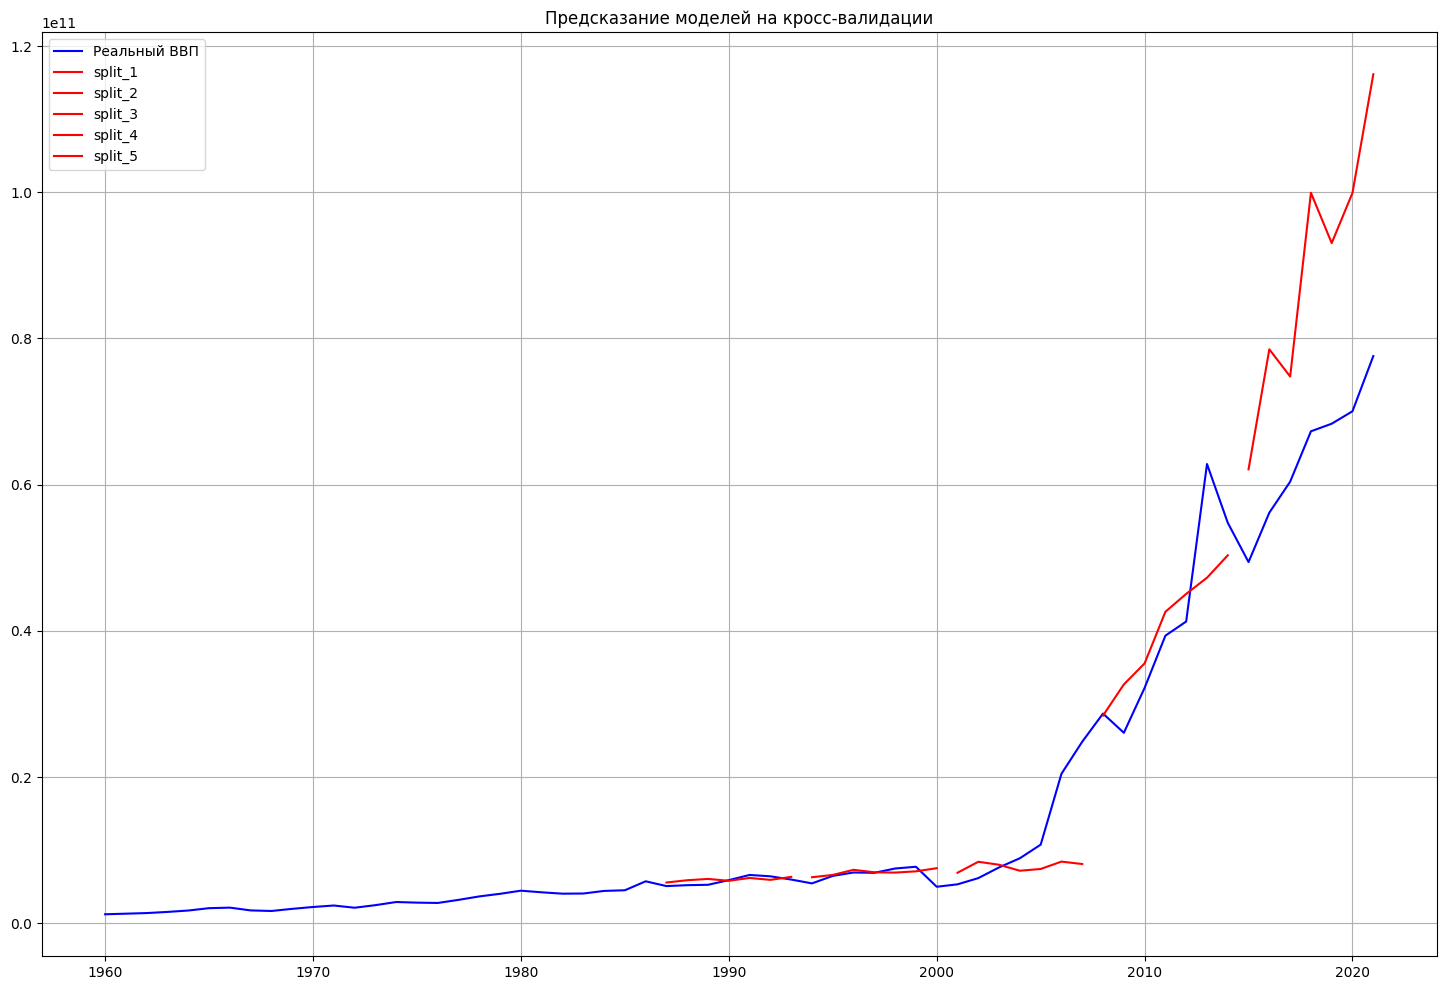

In [47]:
plt.rcParams["figure.figsize"] = 18, 12
plt.grid()

plt.plot(
    pred_df['gdp'],
    color="blue", 
    label="Реальный ВВП"
)
plt.plot(
    pred_df['model_0_preds'],
    color="red", 
    label="split_1"
)
plt.plot(
    pred_df['model_1_preds'],
    color="red", 
    label="split_2"
)
plt.plot(
    pred_df['model_2_preds'],
    color="red", 
    label="split_3"
)
plt.plot(
    pred_df['model_3_preds'],
    color="red", 
    label="split_4"
)
plt.plot(
    pred_df['model_4_preds'],
    color="red", 
    label="split_5"
)
plt.title("Предсказание моделей на кросс-валидации")
plt.legend()

In [48]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

print(f"split_1 R2-score: {round(r2_score(pred_df.loc[pred_df['model_0_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_0_preds'].dropna().index]['model_0_preds']),2)}")
print(f"split_2 R2-score: {round(r2_score(pred_df.loc[pred_df['model_1_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_1_preds'].dropna().index]['model_1_preds']),2)}")
print(f"split_3 R2-score: {round(r2_score(pred_df.loc[pred_df['model_2_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_2_preds'].dropna().index]['model_2_preds']),2)}")
print(f"split_4 R2-score: {round(r2_score(pred_df.loc[pred_df['model_3_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_3_preds'].dropna().index]['model_3_preds']),2)}")
print(f"split_5 R2-score: {round(r2_score(pred_df.loc[pred_df['model_4_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_4_preds'].dropna().index]['model_4_preds']),2)}")
print()
print(f"split_1 MAPE: {round(mape(pred_df.loc[pred_df['model_0_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_0_preds'].dropna().index]['model_0_preds']),2)}")
print(f"split_2 MAPE: {round(mape(pred_df.loc[pred_df['model_1_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_1_preds'].dropna().index]['model_1_preds']),2)}")
print(f"split_3 MAPE: {round(mape(pred_df.loc[pred_df['model_2_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_2_preds'].dropna().index]['model_2_preds']),2)}")
print(f"split_4 MAPE: {round(mape(pred_df.loc[pred_df['model_3_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_3_preds'].dropna().index]['model_3_preds']),2)}")
print(f"split_5 MAPE: {round(mape(pred_df.loc[pred_df['model_4_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_4_preds'].dropna().index]['model_4_preds']),2)}")
print()
print(f"split_1 AIC: {round(cv_aic_0,2)}")
print(f"split_2 AIC: {round(cv_aic_1,2)}")
print(f"split_3 AIC: {round(cv_aic_2,2)}")
print(f"split_4 AIC: {round(cv_aic_3,2)}")
print(f"split_5 AIC: {round(cv_aic_4,2)}")


split_1 R2-score: 0.16
split_2 R2-score: -0.3
split_3 R2-score: -0.29
split_4 R2-score: 0.7
split_5 R2-score: -8.15

split_1 MAPE: 0.08
split_2 MAPE: 0.13
split_3 MAPE: 0.35
split_4 MAPE: 0.12
split_5 MAPE: 0.38

split_1 AIC: 910.7
split_2 AIC: 1199.17
split_3 AIC: 1531.44
split_4 AIC: 1906.36
split_5 AIC: 2286.54


Метрики на кросс-валидации любо-дорого смотреть:

* 1ый и 2ой сплиты показываю плюс-минус адекватные результаты

* на 3ем сплите ВВП Ганны резко **полетел вверх** (интересно связано ли это как - то с падение режима Джерри Роулинга и последующей демократизацией Ганны?)

* на 4ом сплите моделька подстроилась под **уверенный рост** ВВП (нет ну серьёзно, как так получается? Сильный, умный, всеми любимый ворждь уходит и жить всем резко становиться богаче и лучше, чудеса...)

* на 5ом сплите модель сильно обгоняет реальный рост ВВП (необходимо учитывать эффект низкой базы)

***
## 17. Итоговый вариант <a class="anchor" id=17>

[наверх](#0)

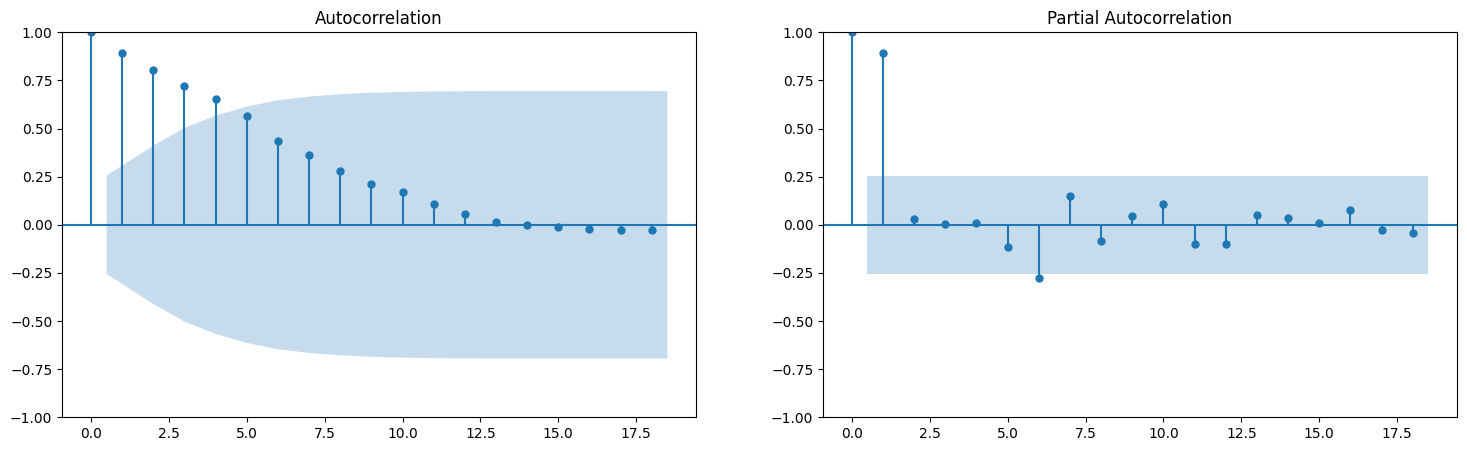

adf:  -2.63463474600784
p-value:  0.08604813722197724
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11198D+01    |proj g|=  3.13345D-01

At iterate    5    f=  2.10204D+01    |proj g|=  4.23944D-02


 This problem is unconstrained.



At iterate   10    f=  2.10173D+01    |proj g|=  8.26565D-03

At iterate   15    f=  2.10131D+01    |proj g|=  1.56047D-01

At iterate   20    f=  2.09952D+01    |proj g|=  1.08478D-01

At iterate   25    f=  2.09710D+01    |proj g|=  7.67184D-02

At iterate   30    f=  2.09618D+01    |proj g|=  1.19739D-02

At iterate   35    f=  2.09611D+01    |proj g|=  2.56075D-02

At iterate   40    f=  2.09401D+01    |proj g|=  3.74658D-02

At iterate   45    f=  2.09336D+01    |proj g|=  2.75546D-02

At iterate   50    f=  2.09331D+01    |proj g|=  1.08914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66   

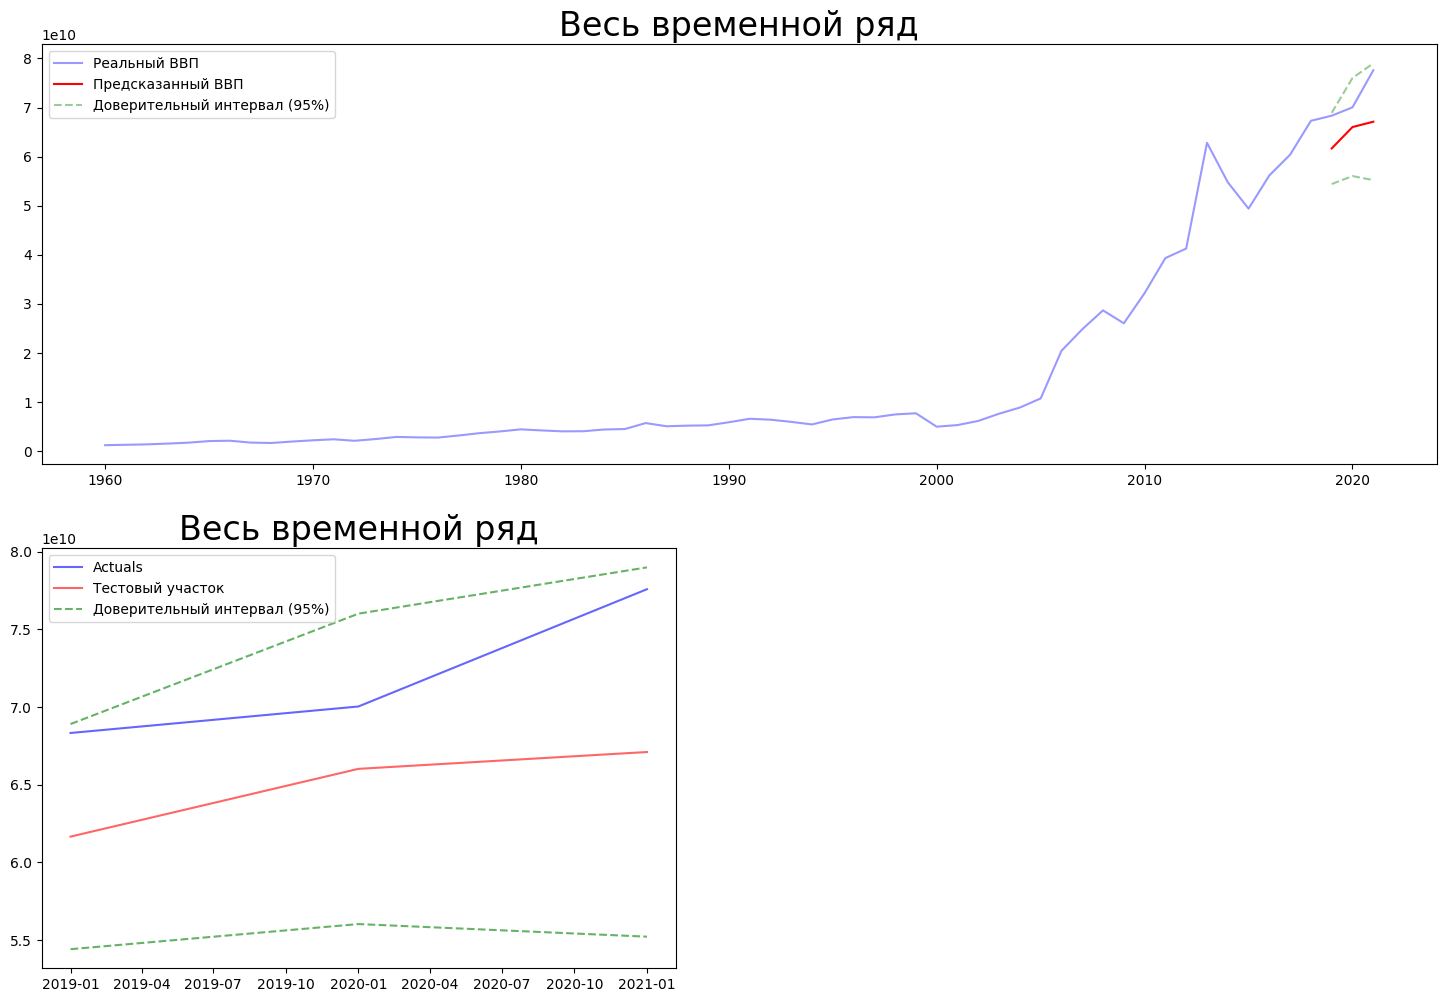

In [49]:
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data = data.rename(columns={'GDP (current US$)':'gdp'})
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)
data = data.interpolate()

train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

plot_acf_pacf(train_df["gdp"].dropna())

test = adfuller(train_df["gdp"].diff().diff().dropna()) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
    
model_best = SARIMAX(
train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit_best = model_inter.fit()

print(model_fit_best.summary())

pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1])


pred_df["gdp"] = data["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Реальный ВВП", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный ВВП",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Тестовый участок",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.show()

## Итоговые выводы:

* Временной ряд имеет явный тренд (на рост)

* По алгоритму выбора модели получаем:

* * Ряд стационарен? **нет**
* * Экзогенные переменные? **нет**
* * Сезонность? **нет**
* * гетероскедастичность? **нет**
* * **ARIMA**

* Предсказания модели показывают несколько меньший рост (что зная специфику графиков роста ВВП является удовлетворительным)

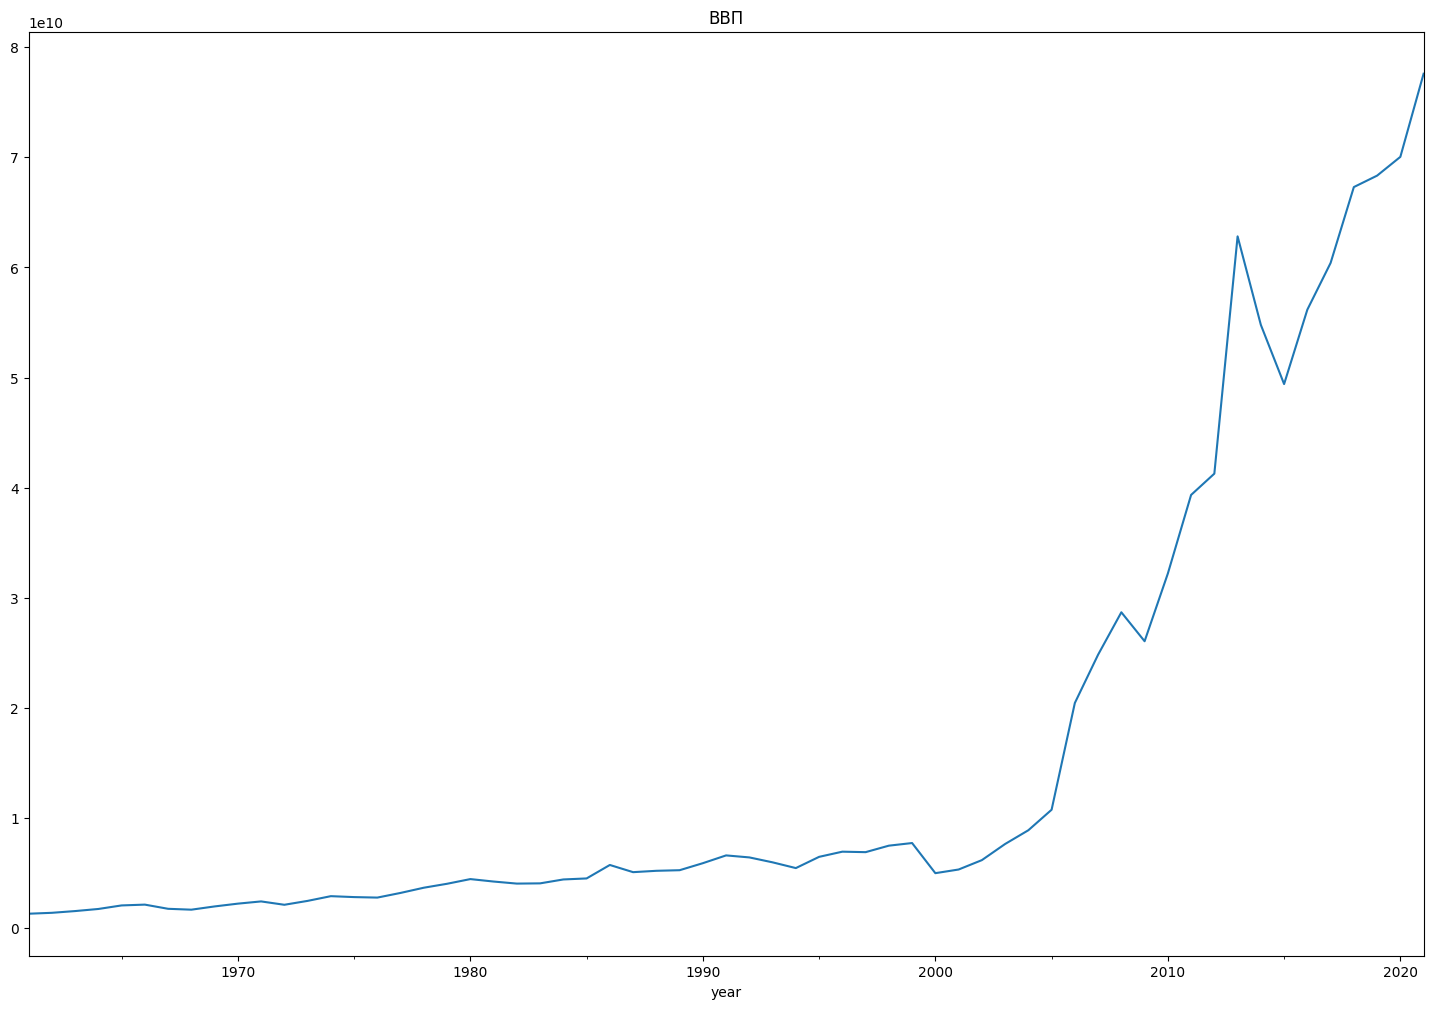

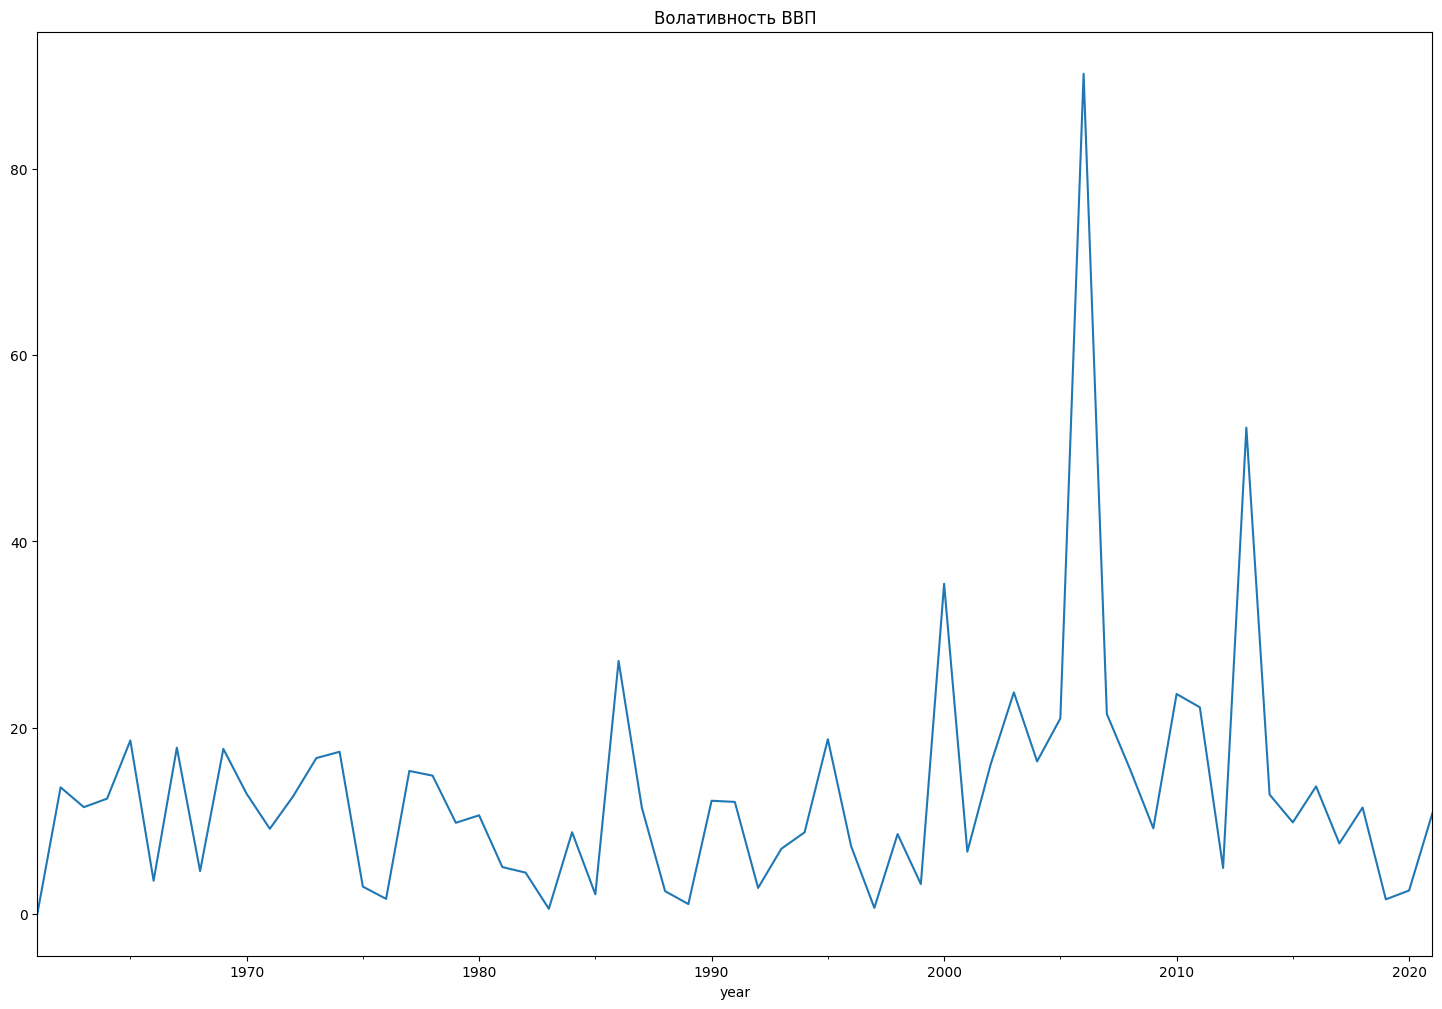

adf:  -6.894157867927704
p-value:  1.3320795444075047e-09
Critical values:  {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
ряд стационарен


In [50]:
# Подготовим ряд и определим волативность
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x==0 else x)  
df['gdp_vol'] = (df['gdp'] - df['gdp'].shift(1))/df['gdp'].shift(1)
df['gdp_vol'] = df['gdp'].pct_change(1).mul(100).abs()
df = df.interpolate()
df = df.dropna()

# Визуализируем данные
df['gdp'].plot()
plt.title('ВВП')
plt.show()

df['gdp_vol'].plot()
plt.title('Волативность ВВП')
plt.show()

test = adfuller(df["gdp_vol"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["1%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157651436415
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1737423172713
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8102947913189
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.00398701138053
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.2403886711335
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475816563683
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.3263815786853
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27319211646926
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26505054533513
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.25168336704354
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66545615407884
Iteration:     12,   Func. Count:     98,   Neg. LLF: 275.9311094518973
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2412199795367
Iteration:     14,   Func. Count:    117,   Neg. LLF: 234

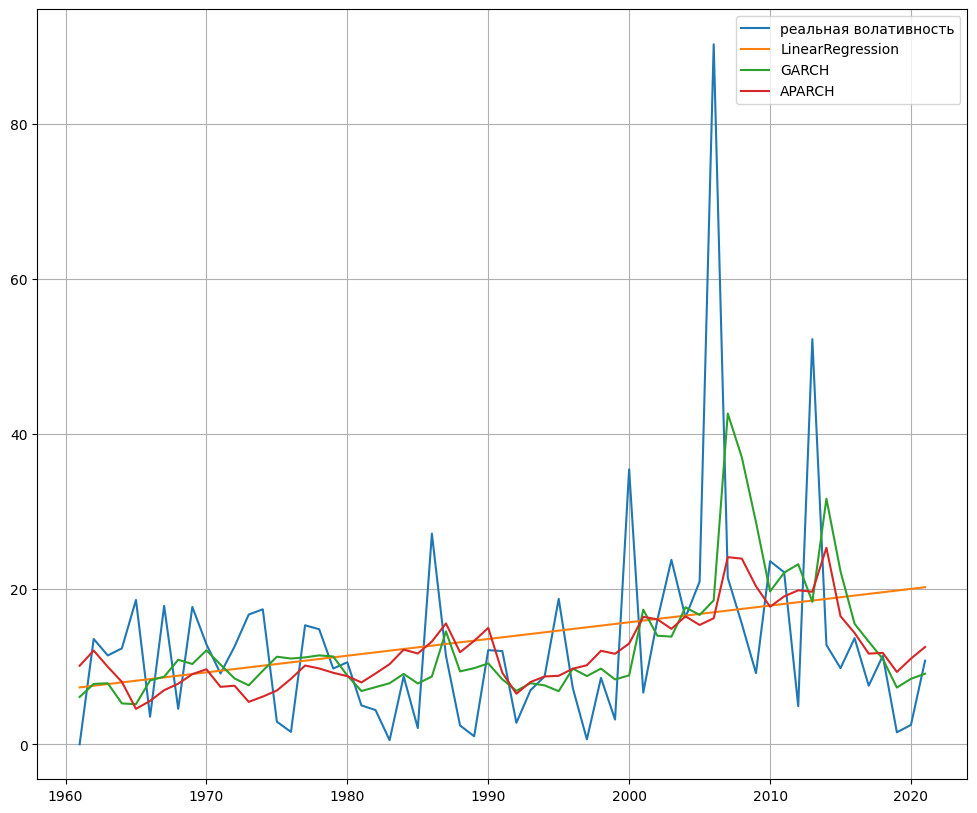

In [51]:
# Разобьём сет на train test
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
X_train = pd.DataFrame(range(df["gdp_vol"].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(df["gdp_vol"].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df["gdp_vol"].values
y_test = test_df["gdp_vol"].values

# Моделируем LR
lr = LinearRegression().fit(X_train, y_train)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
lr_predict = np.append(y_pred_train_lr, y_pred_test_lr)

# Моделируем ARCH
garch = arch_model(df["gdp_vol"], p=2, o=1, q=1, power=0.5, vol='GARCH').fit()
garch_1 = arch_model(df["gdp_vol"], vol='APARCH').fit()

# Отрисуем результаты
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(df['gdp_vol'], label='реальная волативность')
ax.plot(pd.Series(lr_predict, index=df.index), label='LinearRegression')
ax.plot(garch.conditional_volatility, label='GARCH')
ax.plot(garch_1.conditional_volatility, label='APARCH')
ax.grid()
ax.legend();

In [70]:
df

,gdp,gdp_vol
year,,
1961-01-01,1.299720e+09,0.000000
1962-01-01,1.382353e+09,13.578826
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


In [52]:
train_df["gdp_vol"].dropna()

year
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
1965-01-01    18.608414
1966-01-01     3.547067
1967-01-01    17.837977
1968-01-01     4.573826
1969-01-01    17.705882
1970-01-01    12.893553
1971-01-01     9.123051
1972-01-01    12.610723
1973-01-01    16.721166
1974-01-01    17.396804
1975-01-01     2.912634
1976-01-01     1.596101
1977-01-01    15.339433
1978-01-01    14.831798
1979-01-01     9.767969
1980-01-01    10.571547
1981-01-01     5.011815
1982-01-01     4.415626
1983-01-01     0.527271
1984-01-01     8.749833
1985-01-01     2.086502
1986-01-01    27.157362
1987-01-01    11.396962
1988-01-01     2.423944
1989-01-01     1.037417
1990-01-01    12.137075
1991-01-01    12.011383
1992-01-01     2.768791
1993-01-01     6.979306
1994-01-01     8.744096
1995-01-01    18.744891
1996-01-01     7.267395
1997-01-01     0.629794
1998-01-01     8.556579
1999-01-01     3.186566
2000-01-01    35.447657
2001-01-01     6.660324
2002-01-01 

In [53]:
df.index.year.values[::5]

array([1961, 1966, 1971, 1976, 1981, 1986, 1991, 1996, 2001, 2006, 2011,
       2016, 2021])

Iteration:      3,   Func. Count:     23,   Neg. LLF: 240.03577663721506
Iteration:      6,   Func. Count:     42,   Neg. LLF: 229.96925361286844
Iteration:      9,   Func. Count:     61,   Neg. LLF: 227.02169863801961
Iteration:     12,   Func. Count:     79,   Neg. LLF: 227.0110065273098
Iteration:     15,   Func. Count:     96,   Neg. LLF: 227.01092531705518
Optimization terminated successfully    (Exit mode 0)
            Current function value: 227.0109253725155
            Iterations: 15
            Function evaluations: 96
            Gradient evaluations: 15


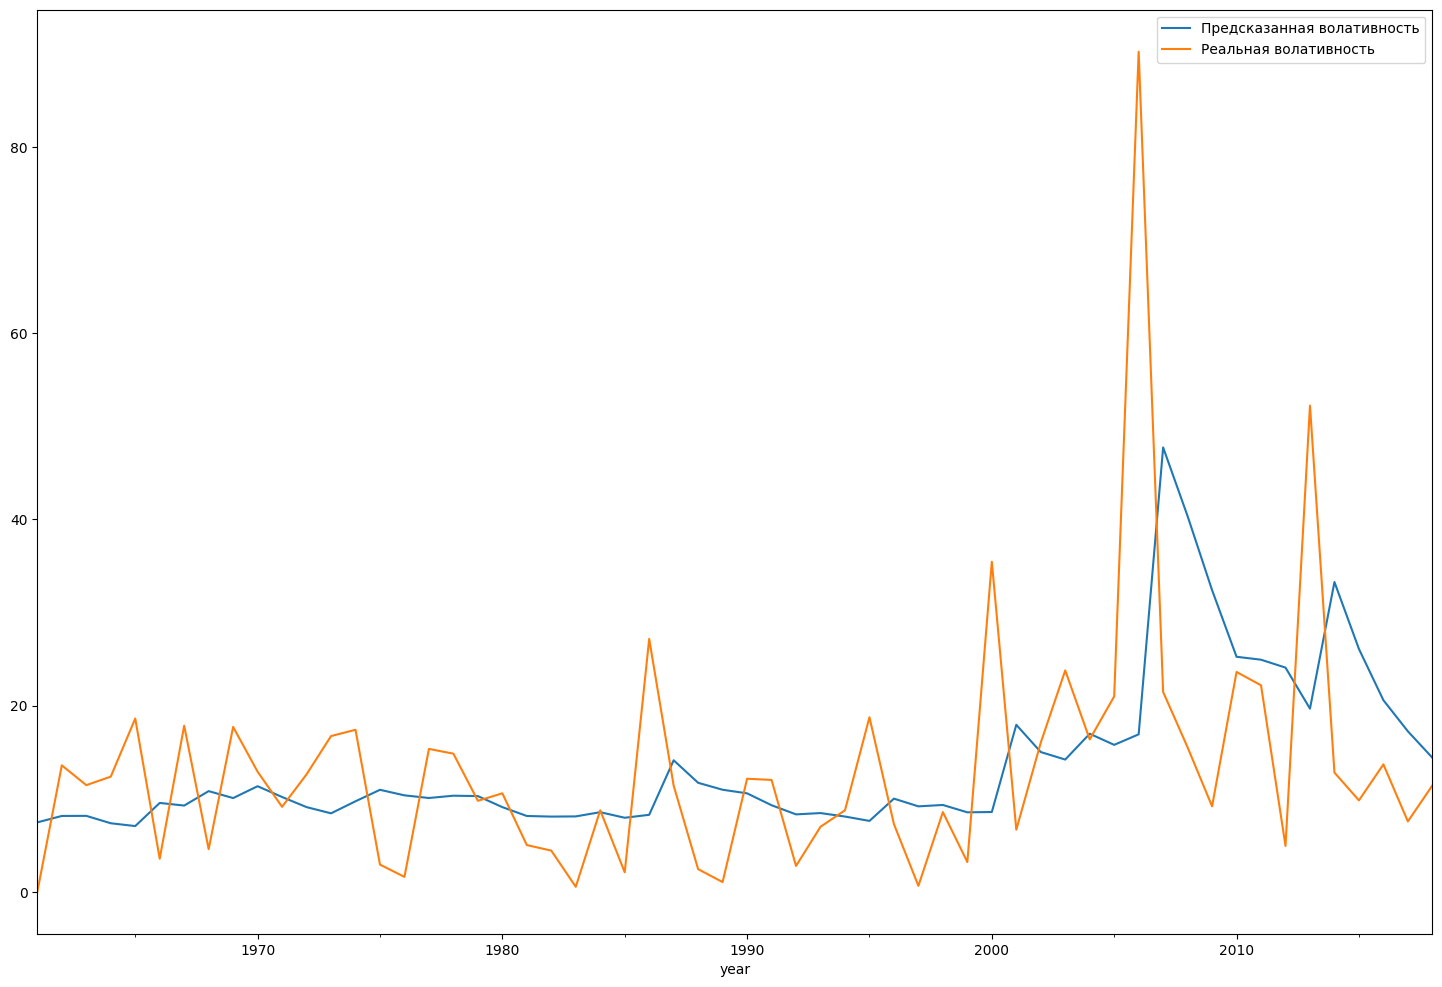

In [54]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

from arch import arch_model
am = arch_model(train_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, train_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

In [55]:
train_df

,gdp,gdp_vol
year,,
1961-01-01,1.299720e+09,0.000000
1962-01-01,1.382353e+09,13.578826
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
1966-01-01,2.126050e+09,3.547067
1967-01-01,1.746806e+09,17.837977
1968-01-01,1.666910e+09,4.573826
1969-01-01,1.962051e+09,17.705882


In [104]:
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data['GDP (current US$)'] = data["GDP (current US$)"].apply(lambda x: np.nan if x==0 else x)  
data["GDP_vol"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()


train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]


#plt.rcParams["figure.figsize"] = 10,4

#plot_acf_pacf(train_df["GDP_vol"][1:])
#plt.show()

#adfuller(train_df["GDP_vol"][1:])

# стационарен, p=1, q=1


garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

from arch import arch_model

model = arch_model(garch_df["GDP_vol"].dropna(), p=2, o=1, q=1, power=0.5, vol='GARCH')
model_results = model.fit()

# 4-кратное улучшение AIC до 461

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.conditional_volatility

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157651436415
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1737423172713
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8102947913189
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.00398701138053
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.2403886711335
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475816563683
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.3263815786853
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27319211646926
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26505054533513
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.25168336704354
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66545615407884
Iteration:     12,   Func. Count:     98,   Neg. LLF: 275.9311094518973
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2412199795367
Iteration:     14,   Func. Count:    117,   Neg. LLF: 234

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157651436415
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1737423172713
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8102947913189
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.00398701138053
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.2403886711335
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475816563683
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.3263815786853
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27319211646926
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26505054533513
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.25168336704354
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66545615407884
Iteration:     12,   Func. Count:     98,   Neg. LLF: 275.9311094518973
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2412199795367
Iteration:     14,   Func. Count:    117,   Neg. LLF: 234

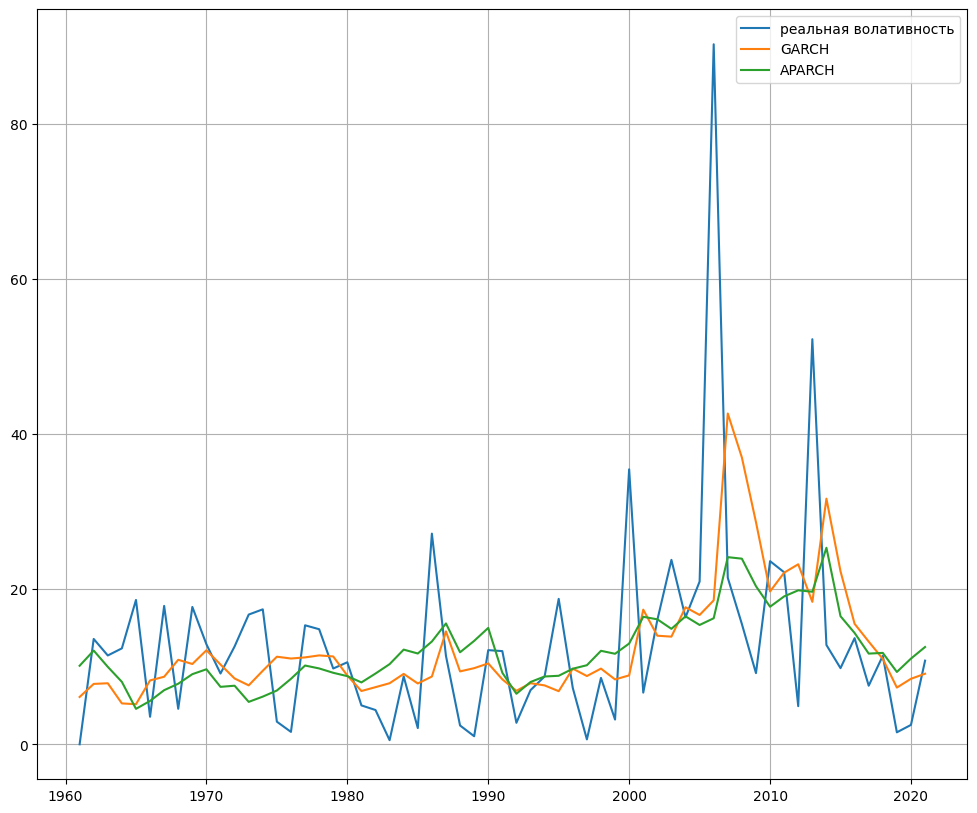

In [113]:
garch = arch_model(data["GDP_vol"].dropna(), p=2, o=1, q=1, power=0.5, vol='GARCH').fit()
garch_1 = arch_model(data["GDP_vol"].dropna(), vol='APARCH').fit()

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(data["GDP_vol"], label='реальная волативность')
ax.plot(garch.conditional_volatility, label='GARCH')
ax.plot(garch_1.conditional_volatility, label='APARCH')
ax.grid()
ax.legend();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 237.47500389125557
Iteration:      2,   Func. Count:     12,   Neg. LLF: 226.55667323629484
Iteration:      3,   Func. Count:     17,   Neg. LLF: 226.48900414034063
Iteration:      4,   Func. Count:     22,   Neg. LLF: 225.92793743879244
Iteration:      5,   Func. Count:     27,   Neg. LLF: 237.23976052114836
Iteration:      6,   Func. Count:     33,   Neg. LLF: 234.63584797338865
Iteration:      7,   Func. Count:     39,   Neg. LLF: 231.94360191539337
Iteration:      8,   Func. Count:     45,   Neg. LLF: 248.19868203013905
Iteration:      9,   Func. Count:     51,   Neg. LLF: 229.21944947677113
Iteration:     10,   Func. Count:     57,   Neg. LLF: 226.92997422997243
Iteration:     11,   Func. Count:     63,   Neg. LLF: 225.25554067343978
Iteration:     12,   Func. Count:     69,   Neg. LLF: 223.95330259923102
Iteration:     13,   Func. Count:     74,   Neg. LLF: 223.44171642643875
Iteration:     14,   Func. Count:     79,   Neg. LL

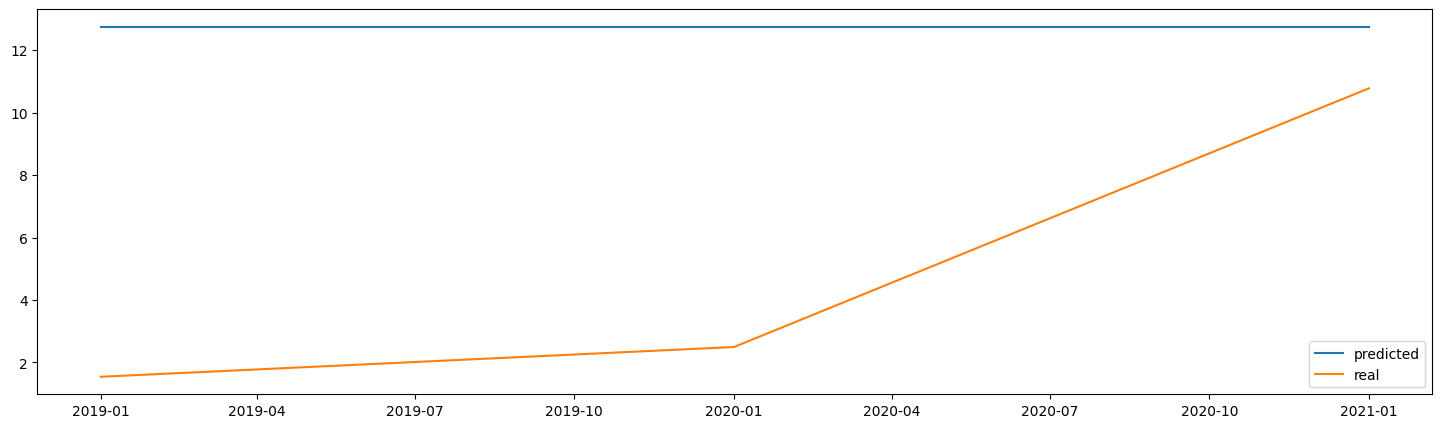

In [182]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

#Читаем и подготавливаем данные
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data['GDP (current US$)'] = data["GDP (current US$)"].apply(lambda x: np.nan if x==0 else x)
data["GDP_vol"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()
data = data.dropna() 
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]

#Моделируем прогноз на последние 3 года
am = arch_model(data['GDP_vol'], vol="GARCH")
res = am.fit(last_obs=dt.datetime(2019,1,1))
forecasts = res.forecast()

#Визуализируем результаты
plt.plot(forecasts.mean[-3:], label='predicted')
plt.plot(test_df['GDP_vol'], label='real')
plt.legend();